In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100, "display.width",2000, "display.max_colwidth",100)

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import re

#### Read Data

In [3]:
input_df = pd.read_csv("protac.csv").reset_index(drop=True)
input_df = input_df.rename(columns={"E3 ligase":"E3ligase"})
print("input_df: {:,} x {:,}".format(*input_df.shape), "(input df) \n")

print("Counts of distinct values in columns")
for x in ["Target","E3ligase"]:
  tmp = input_df.groupby(x, as_index=False).size().sort_values("size", ascending=False, ignore_index=True)
  print(f"col:{x}  (#unique:{tmp.shape[0]:,})")
  print(tmp.head(20).T, "\n")

del tmp

input_df: 3,939 x 84 (input df) 

Counts of distinct values in columns
col:Target  (#unique:289)
         0     1     2    3     4    5    6        7     8     9       10    11    12     13     14    15          16                17   18    19
Target   ER  BRD4  CDK4   AR  CDK6  BTK  ALK  BCR-ABL  BRD3  BRD2  BCL-xL  MEK1  CDK2  PARP1  HDAC6  BRD9  BRAF V600E  EGFR L858R/T790M  FAK  CDK9
size    182   164   143  141   139  106   97       96    77    77      77    76    70     63     60    53          53                52   52    52 

col:E3ligase  (#unique:12)
            0     1      2     3     4    5    6       7       8       9       10    11
E3ligase  CRBN   VHL  cIAP1  XIAP  MDM2  AhR  IAP  DCAF15  DCAF16  RNF114  DCAF11  RNF4
size      2571  1152    122    34    30    9    5       4       4       4       3     1 



E3Ligase Classes

In [4]:
for i in range(len(input_df["E3ligase"])):
    if 'IAP' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='IAP'
    elif 'DCAF' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='DCAF'
    elif 'RNF' in str(input_df.loc[i].at["E3ligase"]):
        input_df.at[i,'E3ligase']='RNF'

tmp = input_df.groupby('E3ligase', as_index=False).size().sort_values("size", ascending=False, ignore_index=True)
print(f"col:{'E3ligase'}  (#unique:{tmp.shape[0]:,})")
print(tmp.head(20).T, "\n")
del tmp


col:E3ligase  (#unique:7)
             0     1    2     3     4    5    6
E3ligase  CRBN   VHL  IAP  MDM2  DCAF  AhR  RNF
size      2571  1152  161    30    11    9    5 



In [5]:
print('Number of Rows with explicit DC50: ' + str((input_df.shape[0] - input_df['DC50 (nM)'].isna().sum())))
#input_df = input_df.dropna(subset=['DC50 (nM)',"Percent degradation (%)"],how='all')
input_df = input_df.dropna(subset=['DC50 (nM)'])
print("input_df: {:,} x {:,}".format(*input_df.shape), "(input df) \n")

Number of Rows with explicit DC50: 638
input_df: 638 x 84 (input df) 



#### Features

Target and E3Ligase

In [6]:
model_df = pd.concat([
    pd.get_dummies(input_df["Target"], prefix="tgt"),
    pd.get_dummies(input_df["E3ligase"], prefix="e3")
  ], axis=1).reset_index(drop=True)

print("model_df: {:,} x {:,}".format(*model_df.shape), "(target and E3ligase OHE features)")

model_df: 638 x 89 (target and E3ligase OHE features)


Molecular Fingerprint

In [7]:
bits = 256

def get_morgan_fp(smiles:str, nbits:int=bits):
  m = Chem.MolFromSmiles(smiles)
  fingerprint = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nbits)
  array = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fingerprint, array)
  return array

smiles = [get_morgan_fp(x).tolist() for x in input_df["Smiles"]]
smiles_df = pd.DataFrame(smiles, columns=["sm"+str(n) for n in range(1,bits+1)])
print("model_df: {:,} x {:,}".format(*model_df.shape))

#assert model_df.columns == smiles_df.columns

model_df = pd.concat([model_df,smiles_df],axis=1)
print("smiles_df: {:,} x {:,}".format(*smiles_df.shape))
print("model_df: {:,} x {:,}".format(*model_df.shape), "(added smiles features)")

del smiles, smiles_df

model_df: 638 x 89
smiles_df: 638 x 256
model_df: 638 x 345 (added smiles features)


Cell Type

In [8]:
celltypes = []
for i in range(input_df.shape[0]):
    row = str(input_df.iloc[i].to_list())
    cell = re.findall('[\w\.;/-]+ cells', row)
    if len(cell)==0:
        celltypes.append('Unknown')
    else:
        celltypes.append(cell[0][:-6])

print('Cell Types: ' + str(set(celltypes)))
len(set(celltypes))
model_df['ct'] = celltypes
model_df = pd.get_dummies(model_df, prefix='ct')
model_df
print("\nmodel_df: {:,} x {:,}".format(*model_df.shape), "(added cell type feature)")

Cell Types: {'MV4-11', 'HCC827', 'SK-MEL-28', 'SW1573', 'MOLT-4', 'OCI-AML2/OCI-AML3/Ramos', 'HCT116', 'Jurkat/MOLT-4/U937', '22RV1', 'U251', 'KYSE-270', 'SK-MEL-246', 'MOLM-14', 'NAMALWA/XLA', 'Molm-16', 'MCF-7', 'NAMALWA', 'MOLT-4/platelets', 'MV-4-11', 'Ramos', 'MM', 'Pfeiffer/DOHH2/K562', 'HCC827/H3255', 'LNCaP/Ramos', 'Molm-16/SU-DHL-1', 'Mino', 'THP-1', 'MCF-7/T47D', 'KYSE520/MV4;11', 'MV4;11', 'HeLa/HEK293', 'Unknown', 'NCI-H2030/MIAPaCa-2/SW1573', 'K562', 'MDA-MB-468', 'LNCaP/VCaP/22Rv1', 'H3255', 'Ramos/THP-1', 'THP1', 'EOL-1/A-204', 'Tu-I', 'Huh7.5', 'NCI-H661/NCI-H838', 'HT-29/SK-MEL-28', 'PBMC', 'VCaP', 'SU-DHL-1/NCI-H2228', 'Sk-Mel-28', 'HCC-827', 'A431', 'HEK293T', 'PC3', 'OVCAR8/HeLa', 'H1666/CAL-12T', 'SUM149', 'HLE/HuH-7/SNU-423', 'HUH-1/HepG2/SK-Hep-1', 'MM1S', 'MV-4-11/NCI-H1568', 'SRD15', 'KM12/HEL', 'SW480', 'Sertoli/germ', 'NCI-H23/NCI-H358', '22Rv1', '4935', 'HeLa', 'Hs578t', 'NCI-H2030', 'SR', 'HeLa/DB', '205', 'MCF7/MDA-MB-231', 'PC-3', 'hPBMC', 'PC-3/LNCaP/MDA

109

,tgt_ABL1,tgt_ADRA1A,tgt_AKT1,tgt_AKT2,tgt_AKT3,tgt_ALK,tgt_ALK G1202R,tgt_AR,tgt_AR-V7,tgt_AURKA,tgt_BCL-xL,tgt_BCL2,tgt_BCR-ABL,tgt_BLK,tgt_BRAF G466V,tgt_BRAF G469A,tgt_BRAF V600E,tgt_BRD2,tgt_BRD3,tgt_BRD4,tgt_BRD4 BD1,tgt_BRD7,tgt_BRD9,tgt_BTK,tgt_BTK C481S,tgt_CD147,tgt_CDK19,tgt_CDK2,tgt_CDK4,tgt_CDK6,tgt_CDK8,tgt_CDK9,tgt_CRBN,tgt_Cdc20,tgt_EED,tgt_EGFR,tgt_EGFR L858R,tgt_EGFR L858R/T790M,tgt_EGFR e19d,tgt_ER,tgt_ERRalpha,tgt_EZH2,tgt_FAK,tgt_FKBP12,tgt_GCN5,tgt_GSK-3beta,tgt_GSK3A,tgt_HDAC3,tgt_HDAC6,tgt_HMGCR,...,ct_MOLT-4/platelets,ct_MV-4-11,ct_MV-4-11/NCI-H1568,ct_MV4-11,ct_MV4;11,ct_Mino,ct_Molm-16,ct_Molm-16/SU-DHL-1,ct_NAMALWA,ct_NAMALWA/XLA,ct_NCI-H2030,ct_NCI-H2030/MIAPaCa-2/SW1573,ct_NCI-H23/NCI-H358,ct_NCI-H661/NCI-H838,ct_Namalwa/CA-46,ct_OCI-AML2/OCI-AML3/Ramos,ct_OVCAR8/HeLa,ct_PBMC,ct_PC-3,ct_PC-3/LNCaP/MDA-MB-231,ct_PC3,ct_PC3-S1,ct_PC9,ct_Pfeiffer/DOHH2/K562,ct_RI-1,ct_Ramos,ct_Ramos/THP-1,ct_SK-MEL-246,ct_SK-MEL-28,ct_SR,ct_SRD15,ct_SU-DHL-1/NCI-H2228,ct_SUM149,ct_SW1573,ct_SW480,ct_SW620,ct_Sertoli/germ,ct_Sk-Mel-28,ct_T47D/MB-MDA-231,ct_THP-1,ct_THP1,ct_TM3/PA1/MDA-MB-436,ct_Tu-I,ct_U251,ct_Unknown,ct_VCaP,ct_WI38,ct_XLA,ct_Z138/HBL-1/Mino,ct_hPBMC
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



model_df: 638 x 454 (added cell type feature)


#### Response Variable (Binary)

In [9]:
# dfstr = input_df.select_dtypes(include=[object])
# rows = dfstr.apply(lambda x: x.str.contains("degradation",case=False)).any(axis=1)
# model_df.insert(0, "resp", rows.values.astype(int))

# print("model_df: {:,} x {:,}".format(*model_df.shape), "(added response variable)")
# del dfstr, rows

#### Response Variable (DC50)

In [10]:
#add and process DC50 column

model_df['resp'] = list(input_df['DC50 (nM)'])
model_df['resp'] = model_df["resp"].str.replace("[<=>]","")
model_df['resp'] = model_df["resp"].str.replace("\(n/a\)","0")
model_df['resp'] = model_df["resp"].str.replace('[\d]+[-~]',"")
model_df = model_df.loc[~model_df['resp'].str.contains('[a-zA-Z]')]

/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_93587/1778872113.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace("[<=>]","")
/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_93587/1778872113.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace("\(n/a\)","0")
/var/folders/vs/8ts0hp5d0wzf8zdrzyqly4840000gn/T/ipykernel_93587/1778872113.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['resp'] = model_df["resp"].str.replace('[\d]+[-~]',"")


Split DC50 by Cell Type

In [11]:
out_nochange = []
out_v1 = []
out_v2 = []
for row in model_df.to_dict(orient="records"):
  #no slashes
  if "/" not in row["resp"]:
    out_nochange.append(row)
    continue
  
  #slashes in resp matched by a column with ct which has same number of slashes
  lst = [k for k,v in row.items() if k.startswith("ct") and "/" in k and v==1]
  assert len(lst) in [0,1]
  if len(lst) == 1:
    #test.append((lst[0],row["resp"]))
    cols = lst[0].split("/")
    vals = row["resp"].split("/")
    assert len(cols)==len(vals)
    assert len(cols) in [2,3]
    
    #adding 2 or 3 rows
    for c,v in zip(cols,vals):
      dct = row.copy()
      k = c if c.startswith("ct_") else "ct_"+c
      dct[k] = 1
      dct["resp"] = v
      del dct[lst[0]]
      out_v1.append(dct)
  else:
    vals = row["resp"].split("/")
    dct = row.copy()
    dct["resp"] = vals[0]
    out_v2.append(dct)
    
    
model_df = pd.DataFrame(out_nochange+out_v1+out_v2)
model_df = model_df.fillna(0)

In [12]:
model_df['resp'] = pd.to_numeric(model_df['resp'])
model_df['resp']

0      560.00
1        4.50
2        1.76
3       34.50
4        4.00
        ...  
706      7.10
707    126.00
708    100.00
709     50.00
710     30.00
Name: resp, Length: 711, dtype: float64

DC50 Distribution and Cutoff Determination

In [27]:
#dropping rows with outlier DC50 values
model_df.drop(model_df.index[model_df['resp'] <= 0], inplace=True)
model_df.loc[model_df.resp>100, 'resp'] = 101

0       101.00
1         4.50
2         1.76
3        34.50
4         4.00
         ...  
707     101.00
708     100.00
709      50.00
710      30.00
True       NaN
Name: resp, Length: 710, dtype: float64


[Text(0.5, 0, 'DC50 Value')]

[Text(0, 0.5, 'Count')]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


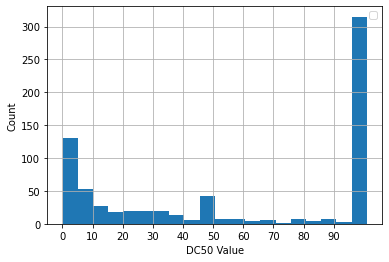

In [28]:
print(model_df['resp'])
ax = model_df['resp'].astype(float).hist(bins = 20)
ax.set(xlabel=f"DC50 Value")
ax.set(ylabel=f"Count")
ax.legend(loc="upper right")
ax.set_xticks(ticks=range(0, 100, 10), minor=False)

In [85]:
# print("model_df: {:,} x {:,}".format(*model_df.shape), "(DC50 values filtered)")
# print("25th percentile: " + str(model_df['resp'].quantile(.25)))
# print("50 percentile: " + str(model_df['resp'].quantile(.50)))
# print("75 percentile: " + str(model_df['resp'].quantile(.75)))
model_df.loc[model_df.resp<=10.0, 'resp_categorical'] = '0'
#model_df.loc[(model_df.resp<=100.0).any() and (model_df.resp>10.0).any(), 'resp_categorical'] = '1'
model_df.loc[model_df.resp>100.0, 'resp_categorical'] = '2'
model_df['resp_categorical'] = model_df['resp_categorical'].fillna('1')
model_df.drop(model_df.tail(1).index,inplace=True) # drop last row of nans

#### Model Matrices

In [87]:
train,test = train_test_split(model_df, random_state=1, test_size=.2)

features = train.columns.tolist()[1:-1]  #dropping "resp"
print(f"nfeatures: {len(features):,}")

X_train = train.drop(["resp_categorical","resp"], axis=1).values
print("x train before: {:,} x {:,}".format(*X_train.shape), "(x df) \n")
y_train = train["resp_categorical"].values

X_test = test.drop(["resp_categorical","resp"], axis=1).values
y_test = test["resp_categorical"].values

del train, test

nfeatures: 505
x train before: 566 x 505 (x df) 



In [88]:
def eval_classifier(clf):
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)

  stats = [
    ["train",roc_auc_score(y_train,y_train_pred), average_precision_score(y_train,y_train_pred)],
    ["test",roc_auc_score(y_test,y_test_pred), average_precision_score(y_test,y_test_pred)]
  ]
  
  with pd.option_context("display.float_format", "{:,.2%}".format):
    print(pd.DataFrame(stats, columns=["","AUC","AP"]))

#### Model: RandomForest
```
min_samples_leaf  minimum number of samples required to be at a leaf node (incrementing to reduce overfitting)
```

In [101]:
# for msl in [10,5,2]:
#   print(f"min_samples_leaf:{msl}")
#   clf = RandomForestClassifier(random_state=10, n_estimators=50, min_samples_leaf=msl).fit(X_train,y_train)
#   eval_classifier(clf)
  
# del clf, msl

clf = RandomForestClassifier(random_state=10, n_estimators=50, min_samples_leaf=2).fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(r2_train, r2_test)

0.718501326259947 0.20764455604380272


In [102]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_test_pred)
mse

0.5633802816901409

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test, y_test_pred))

[[28 10  5]
 [ 3 23 13]
 [ 7  6 47]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        43
           1       0.59      0.59      0.59        39
           2       0.72      0.78      0.75        60

    accuracy                           0.69       142
   macro avg       0.68      0.67      0.68       142
weighted avg       0.69      0.69      0.69       142

0.6901408450704225
